# Disentangling lineage relationships of delta and epsilon cells in pancreatic development with the {class}`~moscot.problems.time.TemporalProblem`

In this tutorial, we showcase using gene expression and chromatin accessability to analyze the temporal trajectory of delta and epsilon cells during mouse pancreatic development.

## Mapping cells across time points

Given measurements of any modality across time we can reconstruct the trajectories by mapping cells across time. We assume that we have the same measurement at each time point, resulting in a W-type OT problem.

The reconstruction of these trajectories is crucial in various applications, like understanding the pancretic development in mice. In this specific example
researchers have been hypothesizing about the complex lineage specifications of delta and epsilon cells during the developmental phase, which appear to 
be connected. Here we examine these lineages by modelling the trajectories using the {class}`~moscot.problems.time.TemporalProblem`.

## Preliminaries

In [1]:
import os
import warnings

import moscot as mt
import moscot.plotting as mpl
import mplscience
from moscot.problems.time import TemporalProblem

import jax
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import scanpy as sc

plt.rcParams["legend.scatterpoints"] = 1
sc.set_figure_params(scanpy=True, dpi=80, dpi_save=200)

warnings.simplefilter("ignore", UserWarning)
warnings.simplefilter("ignore", FutureWarning)

### Dataset description

The {func}`~moscot.datasets.pancreas_multiome` dataset (cite) contains  and includes, among other:

- {attr}`obs['stage'] <mudata.MuData.obs>`, representing the developmental stage for cells at time points `E14.5`, `E15.5`, and `E16.5`.
- {attr}`obs['cell_type'] <mudata.MuData.obs>`, representing the cell types present in the pancreas during development.
- {attr}`obsm['X_MultiVI'] <mudata.MuData.obsm>`, a feature space containing information about both gene expression and chromatin accessibility 

In [2]:
mudata = mt.datasets.pancreas_multiome(
    rna_only=False, force_download=False
)  # TODO remove force dl in final push

We only care about a subset of cell types in the dataset, therefore we will filter out all cells that are not relevant for our analysis.

In [3]:
endocrine_celltypes = [
    "Ngn3 low",
    "Ngn3 high",
    "Ngn3 high cycling",
    "Fev+",
    "Fev+ Alpha",
    "Fev+ Beta",
    "Fev+ Delta",
    "Eps. progenitors",
    "Alpha",
    "Beta",
    "Delta",
    "Epsilon",
]

mudata = mudata[mudata.obs["cell_type"].isin(endocrine_celltypes)].copy()

To simplify processing, we will work with an {class}`~anndata.AnnData` object and create {attr}`obs['time'] <anndata.AnnData.obs>` which is {attr}`obs['stage'] <anndata.AnnData.obs>` transformed from string to float.

In [4]:
def adapt_time(x):
    if x["stage"] == "E14.5":
        return 14.5
    if x["stage"] == "E15.5":
        return 15.5
    if x["stage"] == "E16.5":
        return 16.5
    raise ValueError


adata = mudata["rna"]
adata.obsm["X_MultiVI"] = mudata.obsm["X_MultiVI"]
adata.obsm["X_umap"] = mudata.obsm["X_umap"]
adata.obs["cell_type_refined"] = mudata.obs["cell_type_refined"]
adata.obs["time"] = adata.obs.apply(adapt_time, axis=1).astype("category")

We can visualize the data by considering the cell type annotations in a precomputed UMAP.

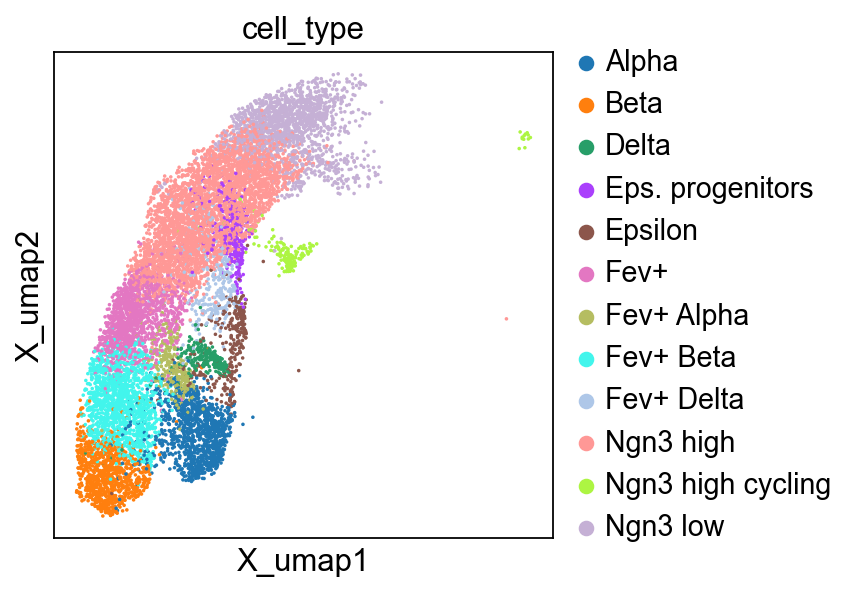

In [5]:
sc.pl.embedding(adata, basis="X_umap", color="cell_type")

## Compute cost matrix and train the model

Since we have three different time points `E14.5`, `E15.5`, and `E16.5`, we will examine two separate temporal problems. The first problem analyzes the temporal trajectory from cells at `E14.5` to cells at `E15.5`, while the second problem does the same for `E15.5` and `E16.5`. The cost matrices for both problems are calculated based on the euclidian distance between cells in the space defined by {attr}`obsm['X_MultiVI'] <anndata.AnnData.obsm>`.

In [6]:
import networkx as nx

dfs = {}
batch_column = "time"
unique_batches = [14.5, 15.5, 16.5]
for i in range(len(unique_batches) - 1):
    batch1 = unique_batches[i]
    batch2 = unique_batches[i + 1]

    indices = np.where(
        (adata.obs[batch_column] == batch1) | (adata.obs[batch_column] == batch2)
    )[0]
    adata_subset = adata[indices]
    sc.pp.neighbors(adata_subset, use_rep="X_MultiVI", n_neighbors=30)
    G = nx.from_numpy_array(adata_subset.obsp["connectivities"].A)
    assert nx.is_connected(G)

    dfs[(batch1, batch2)] = pd.DataFrame(
        index=adata_subset.obs_names,
        columns=adata_subset.obs_names,
        data=adata_subset.obsp["connectivities"].A.astype("float"),
    )

C:\Users\Leon\anaconda3\envs\moscot39\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Prepare the {class}`~moscot.problems.time.TemporalProblem`

First, we instantiate the {class}`~moscot.problems.time.TemporalProblem`

In [7]:
tp0 = TemporalProblem(adata)

To prepare the problem, we need to pass some information:

- `time_key`: defines the {attr}`obs <anndata.AnnData.obs>` column for the temporal information.
- `joint_attr`: defines based on which (latent) space we compute the distances for the OT problem. In this case, we use the latent space {attr}`obsm['X_MultiVI'] <anndata.AnnData.obsm>` described above. 

:::{seealso}
- See {doc}`../examples/problems/400_subset_policy` on how to choose pairs of time points between which to compute OT maps. 
:::

In [8]:
tp0 = tp0.prepare(time_key="time", joint_attr="X_MultiVI")

We then pass our previously computed cost matrices using {func}moscot.base.problems.BirthDeathProblem.set_graph_xy

:::{seealso}
- See {doc}`../examples/problems/200_custom_cost_matrices` for further details on how to pass precomputed cost matrices. 
:::

In [9]:
tp0[14.5, 15.5].set_graph_xy((dfs[14.5, 15.5]).astype("float"), t=100.0)
tp0[15.5, 16.5].set_graph_xy((dfs[15.5, 16.5]).astype("float"), t=100.0)

## Solve the {class}`~moscot.problems.time.TemporalProblem`

Now we can solve the problem. We set `epsilon` to be relatively small to get a sparse mapping between cells. `scale_cost` is set to `mean`, which simply means that we normalize the entries of the cost matrix by its mean to stabilize training. We also introduce an additional stopping criterion, which is
activated if the number of iterations of the Sinkhorn algorithm exceeds one billion by setting `max_iterations` to `1e7`.

In [11]:
# tp0 = tp0.solve(epsilon=1e-3, scale_cost="mean", max_iterations=1e7)
tp0 = TemporalProblem.load(
    "TemporalProblemPancreasFull.pkl"
)  # TODO delete line and resolve problem in final push

## Identifying ancestors and descendants of cells.

We can now examine the ancestors and descendants of a certain cell type. We do this by aggregating the transport matrix by cell type, using {meth}`~moscot.problems.time.TemporalProblem.cell_transition`. First we investigate which ancestry population a certain cell type has. We again leave out
all cell types which are not relevant for our examination.

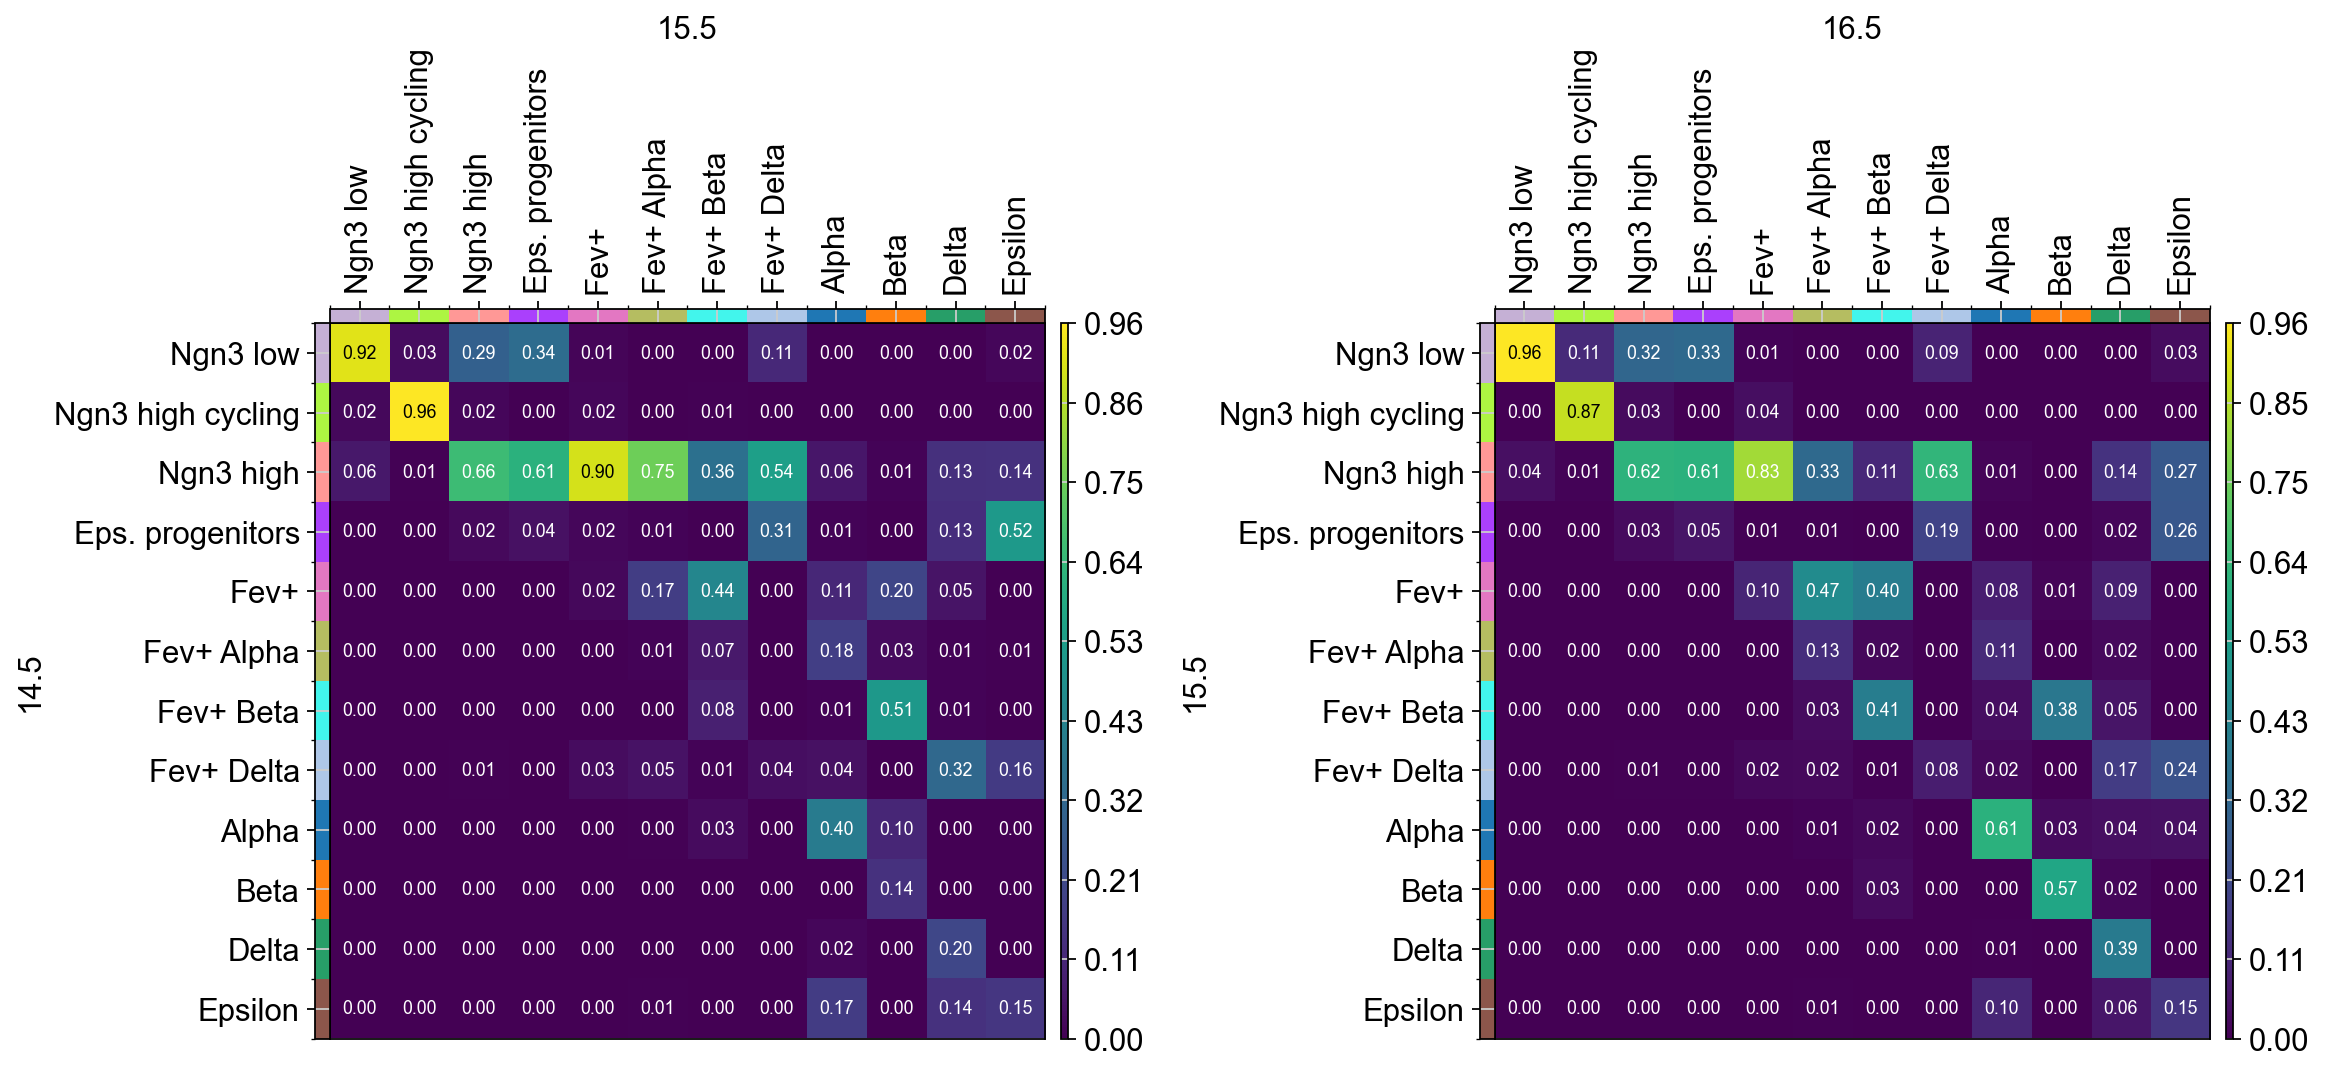

In [12]:
order_celltypes = [
    "Ngn3 low",
    "Ngn3 high cycling",
    "Ngn3 high",
    "Eps. progenitors",
    "Fev+",
    "Fev+ Alpha",
    "Fev+ Beta",
    "Fev+ Delta",
    "Alpha",
    "Beta",
    "Delta",
    "Epsilon",
]

ct_desc = tp0.cell_transition(
    14.5,
    15.5,
    {"cell_type": order_celltypes},
    {"cell_type": order_celltypes},
    forward=False,
    key_added="transitions_14.5_15.5_large",
)
ct_desc = tp0.cell_transition(
    15.5,
    16.5,
    {"cell_type": order_celltypes},
    {"cell_type": order_celltypes},
    forward=False,
    key_added="transitions_15.5_16.5_large",
)

# Create a 1x2 grid of subplots
fig, axes = plt.subplots(ncols=2, figsize=(16, 6))

axes[0] = mpl.cell_transition(
    tp0,
    fontsize=8,
    figsize=(5, 5),
    return_fig=True,
    ax=axes[0],
    key="transitions_14.5_15.5_large",
)

axes[1] = mpl.cell_transition(
    tp0,
    fontsize=8,
    figsize=(5, 5),
    return_fig=True,
    ax=axes[1],
    key="transitions_15.5_16.5_large",
)


fig.subplots_adjust(wspace=0.4)

The transition matrices shows the ancestry of each cell type. For example, looking at the columns of the left transition matrix, we see that both epsilon
and delta cells at time point `15.5` are derived from a similiar group of ancestors consisting of Ngn3 high, epsilon progenitor and Fev+ delta cells,
while also developing from their own cell type.

Next we will examine the descendant of each selected cell type:

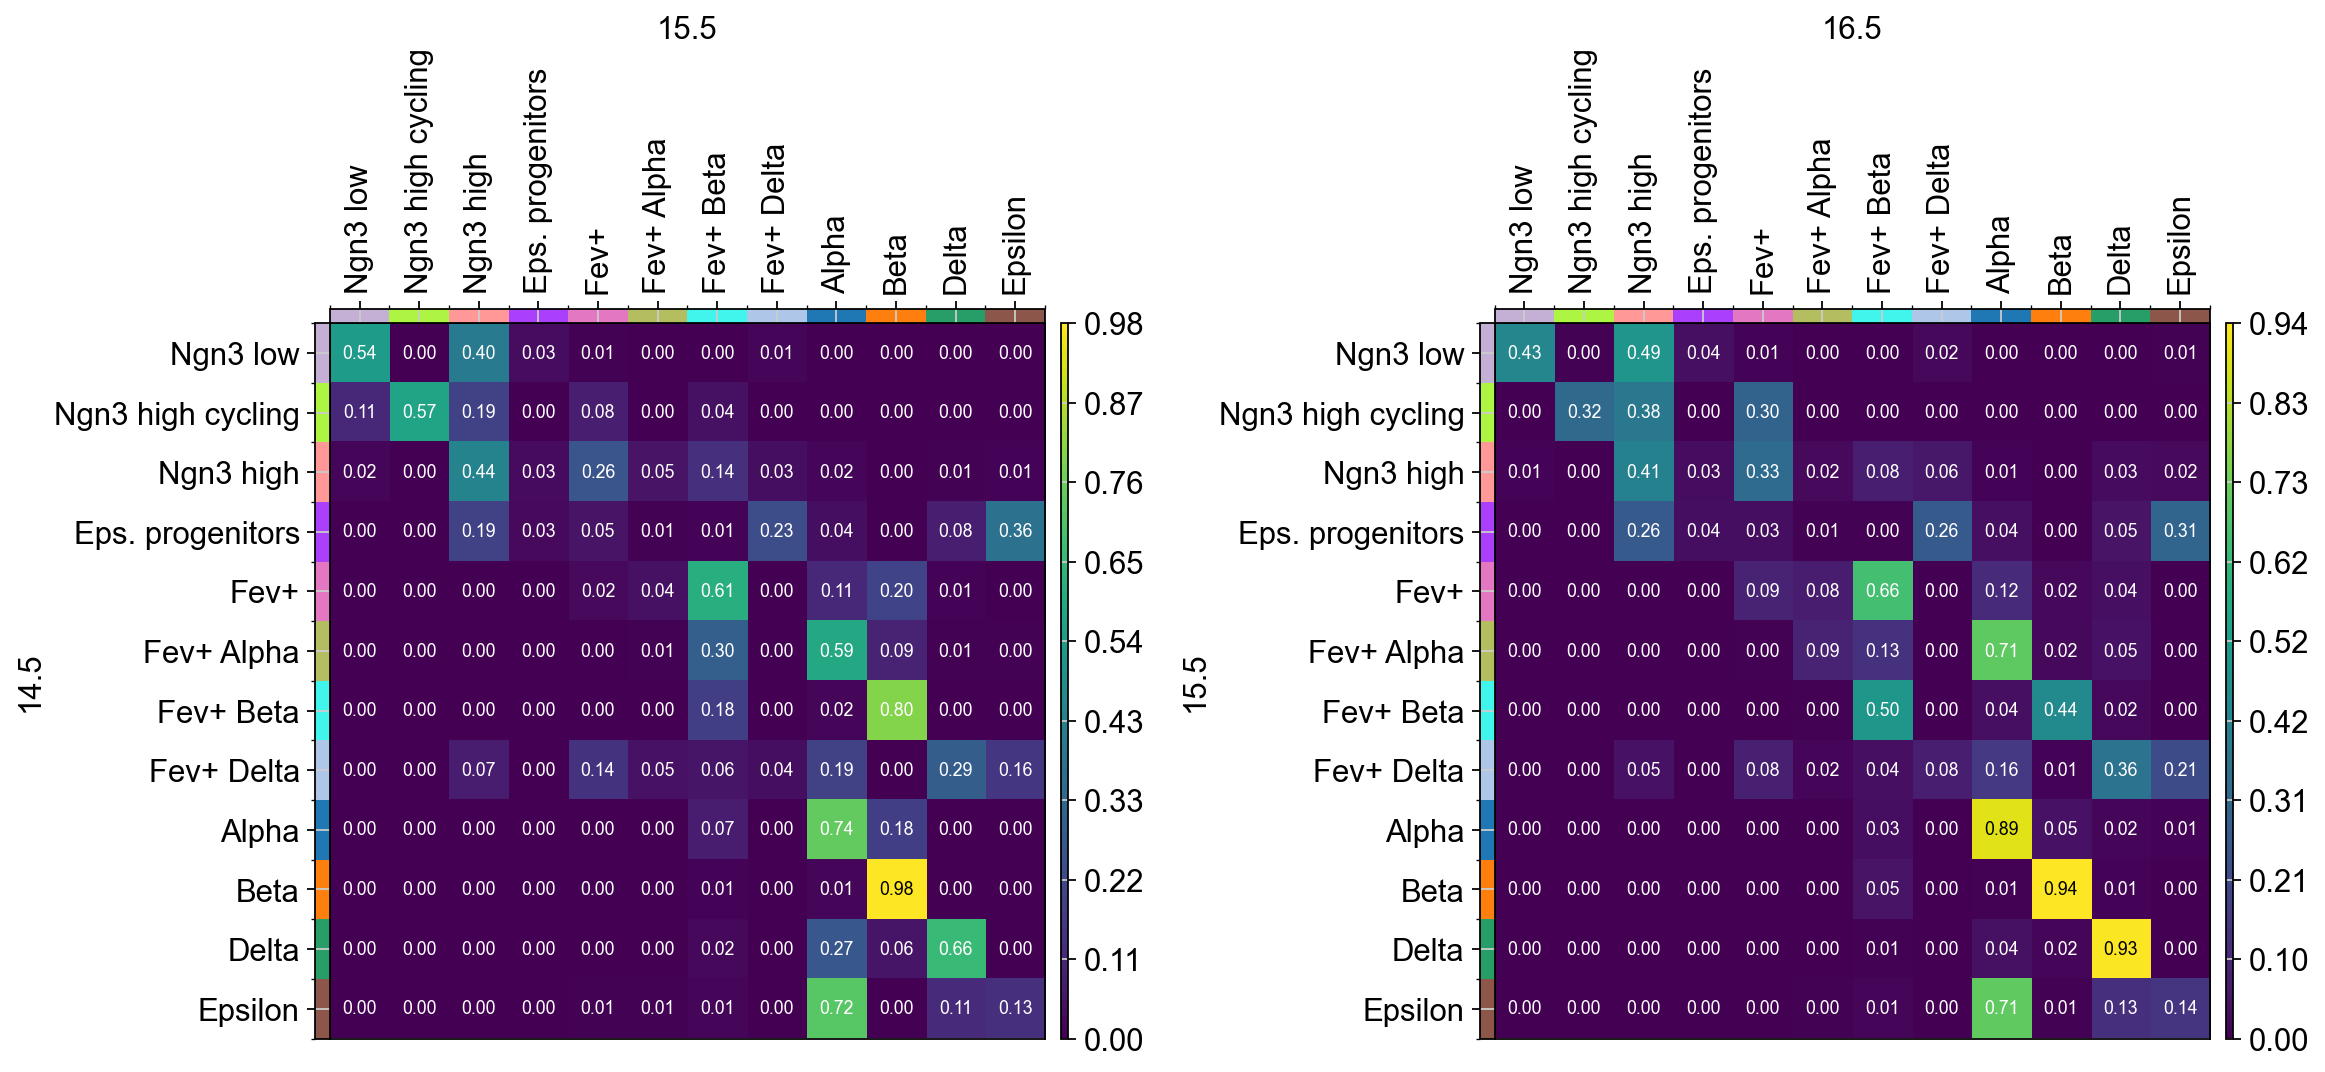

In [13]:
ct_desc = tp0.cell_transition(
    14.5,
    15.5,
    {"cell_type": order_celltypes},
    {"cell_type": order_celltypes},
    forward=True,
    key_added="transitions_14.5_15.5",
)
ct_desc = tp0.cell_transition(
    15.5,
    16.5,
    {"cell_type": order_celltypes},
    {"cell_type": order_celltypes},
    forward=True,
    key_added="transitions_15.5_16.5",
)

# Create a 1x2 grid of subplots
fig, axes = plt.subplots(ncols=2, figsize=(16, 6))

axes[0] = mpl.cell_transition(
    tp0,
    fontsize=8,
    figsize=(5, 5),
    return_fig=True,
    ax=axes[0],
    key="transitions_14.5_15.5",
)

axes[1] = mpl.cell_transition(
    tp0,
    fontsize=8,
    figsize=(5, 5),
    return_fig=True,
    ax=axes[1],
    key="transitions_15.5_16.5",
)


fig.subplots_adjust(wspace=0.4)

Looking at the rows of the right transition matrix we see that mature endocrine (alpha, beta, delta and epsilon) cells at time points `15.5` mostly evolve
into themselves, with one exception to this being epsilon cells which appear to be developing primarily into alpha cells.

## Visualizing ancestors and descendants

We can also visualize ancestors and descendants, e.g. on a UMAP, by using the {func}`~moscot.plotting.pull` and {func}`~moscot.plotting.push`, respectively. We start with ancestors of delta cells at time point `15.5`.

:::{seealso}
- See {doc}`../examples/plotting/100_push_pull` for further details on how to use {func}`~moscot.plotting.pull` and {func}`~moscot.plotting.push`.
:::

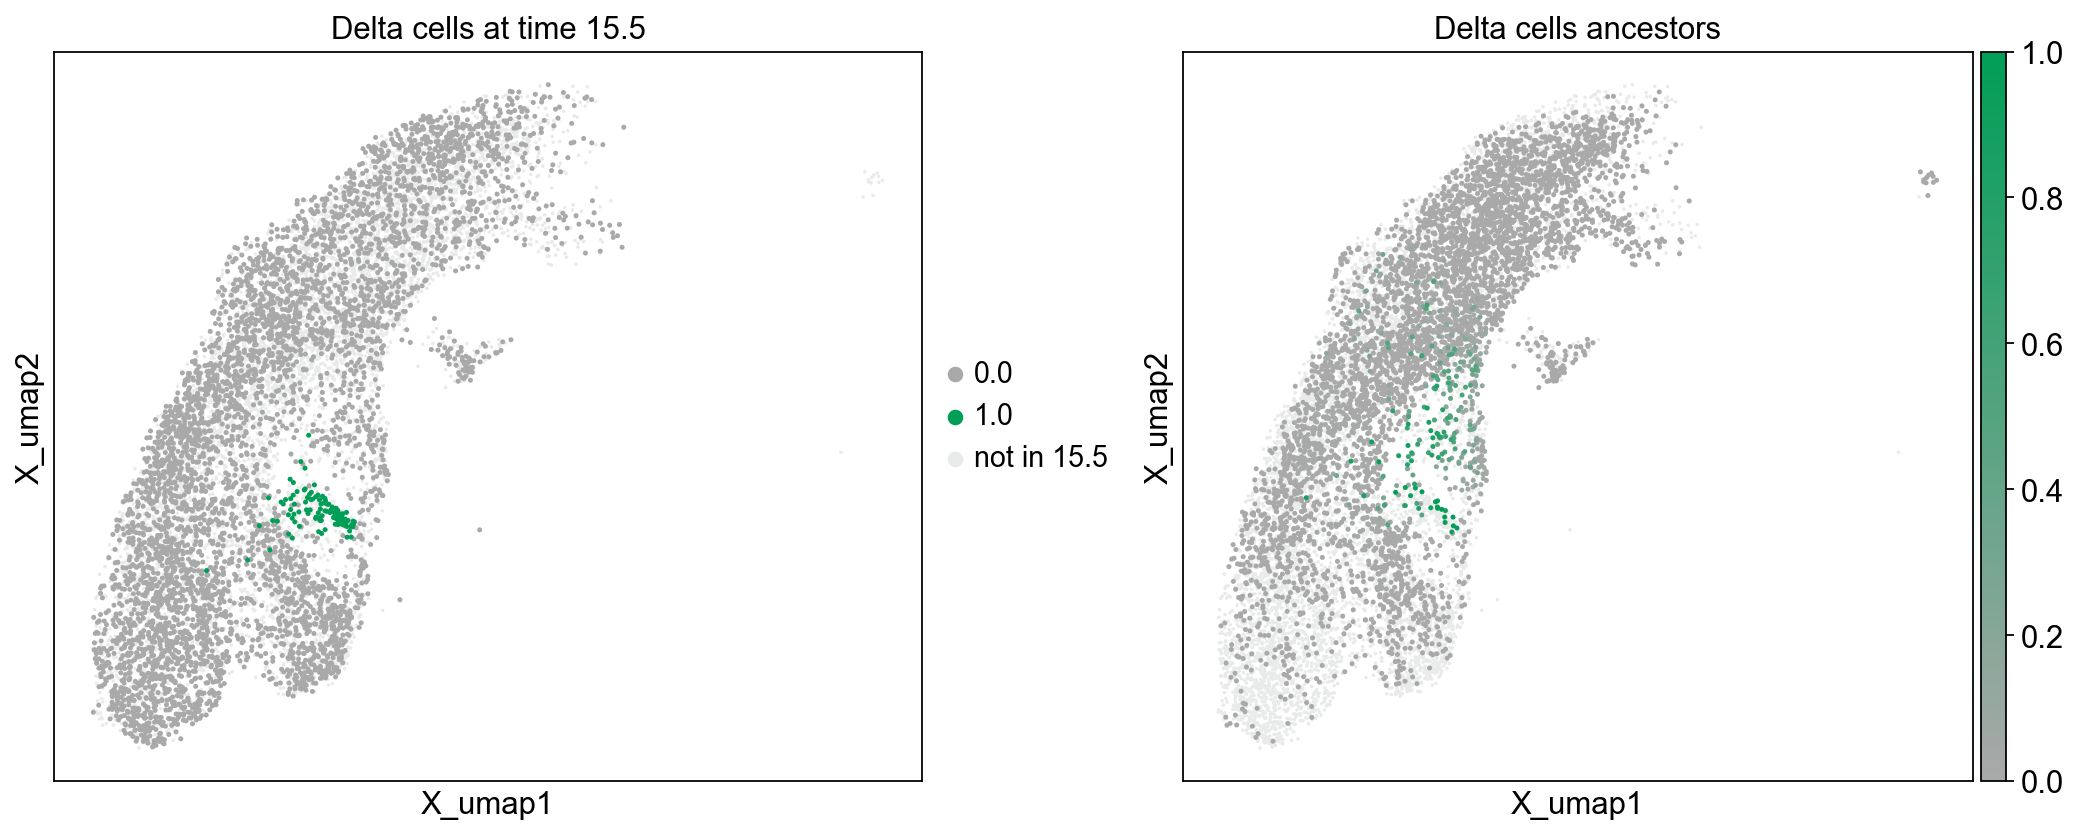

In [14]:
tp0.pull(source=14.5, target=15.5, data="cell_type", subset="Delta")
fig, axes = plt.subplots(ncols=2, figsize=(16, 6))

mpl.pull(
    tp0,
    time_points=[15.5],
    basis="X_umap",
    ax=axes[0],
    title=["Delta cells at time 15.5"],
)

mpl.pull(
    tp0,
    time_points=[14.5],
    basis="X_umap",
    ax=axes[1],
    title=["Delta cells ancestors"],
)

fig.subplots_adjust(wspace=0.3)

The left plot above colorizes all delta cells at time point `15.5` in green. All other cells in time point `15.5` are dark gray, while cells not measured at time point `15.5` are light gray. The right plot shows the ancestry likelihood of each cell at time point `14.5` on a palette from green (very likely ancestor) to dark gray (very unlikely ancestor). All cells not belonging to time point `14.5` are light gray.

We can also visualize the descendants of a certain subgroup. For example, we can visualize the descendants of epsilon cells at time point `14.5`.

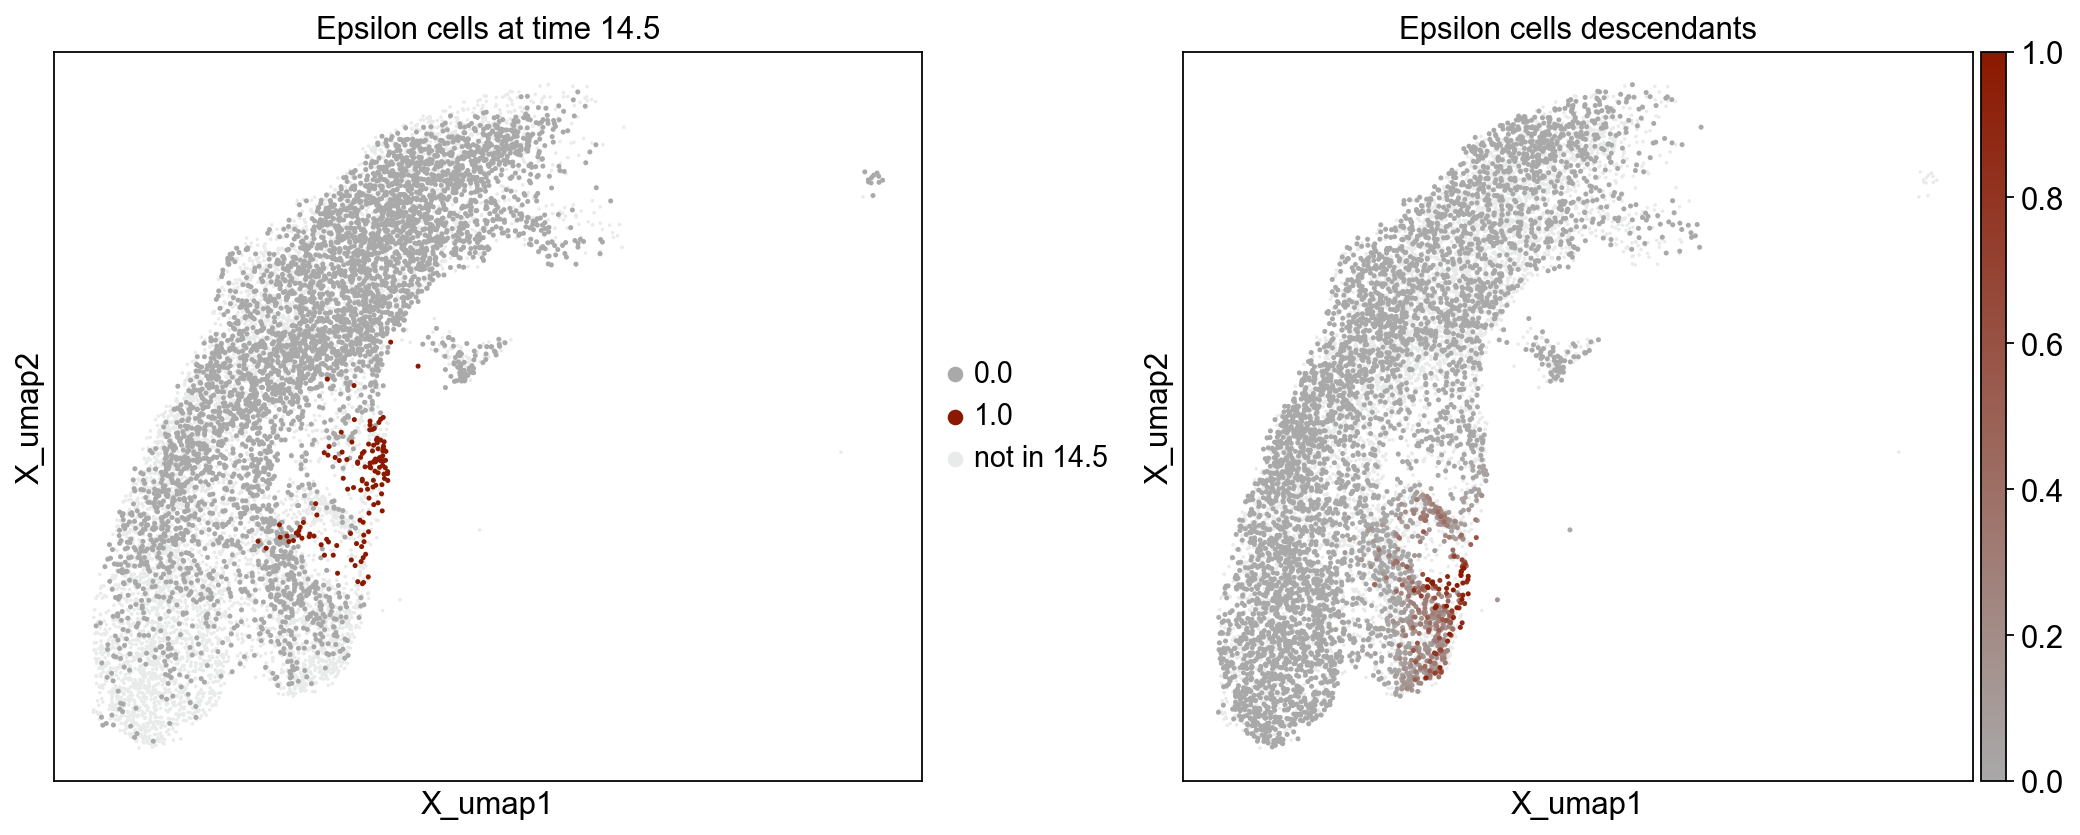

In [15]:
tp0.push(source=14.5, target=15.5, data="cell_type", subset="Epsilon")
fig, axes = plt.subplots(ncols=2, figsize=(16, 6))

mpl.push(
    tp0,
    time_points=[14.5],
    basis="X_umap",
    ax=axes[0],
    title=["Epsilon cells at time 14.5"],
)

mpl.push(
    tp0,
    time_points=[15.5],
    basis="X_umap",
    ax=axes[1],
    title=["Epsilon cells descendants"],
)

fig.subplots_adjust(wspace=0.3)

We can visualize the predicted cell evolution using a {func}`~moscot.plotting.sankey` diagram for the two problems from time points `14.5` to `15.5` and
from `15.5` to `16.5`. For simplicity we use a different, smaller subset of cell types including the mature endocrine cells, epsilon progenitor cells and 
two different types of Fev+ delta cells. Since the cell colors are not directly provided by the dataset we have to define them first. Additionally we
choose `threshold=0.05`, which ignores all transitions with a probability of less than `0.05`.

In [16]:
cluster_subset = [
    "Eps. progenitors",
    "Fev+ Delta,0",
    "Fev+ Delta,1",
    "Alpha",
    "Beta",
    "Delta",
    "Epsilon",
]

tp0.sankey(
    source=14.5,
    target=16.5,
    source_groups={"cell_type_refined": cluster_subset},
    target_groups={"cell_type_refined": cluster_subset},
    threshold=0.05,
    order_annotations=cluster_subset[::-1],
    normalize=True,
)

In [17]:
color_dict = {
    "Prlf. Ductal": "#f7b6d2",
    "Ductal": "#d62728",
    "Imm. Acinar": "#ffeb3b",
    "Mat. Acinar": "#98df8a",
    "Alpha": "#1f77b4",
    "Beta": "#ff7f0e",
    "Delta": "#279e68",
    "Eps. progenitors": "#aa40fc",
    "Epsilon": "#8c564b",
    "Fev+": "#e377c2",
    "Fev+ Alpha": "#b5bd61",
    "Fev+ Beta": "#42f5ec",
    "Fev+ Delta": "#aec7e8",
    "Fev+ Delta,0": "#17becf",
    "Fev+ Delta,1": "#98df8a",
    "Ngn3 high cycling": "#adf542",
    "Ngn3 high,0": "#ff9896",
    "Ngn3 high": "#ff9896",
    "Ngn3 high,1": "#f0b98d",
    "Ngn3 low": "#c5b0d5",
}
tp0.adata.uns["cell_type_refined_colors"] = [
    color_dict[ct] for ct in tp0.adata.obs["cell_type_refined"].cat.categories
]
# TODO check if solved by adding cell_type_refined_color from mudata to adata

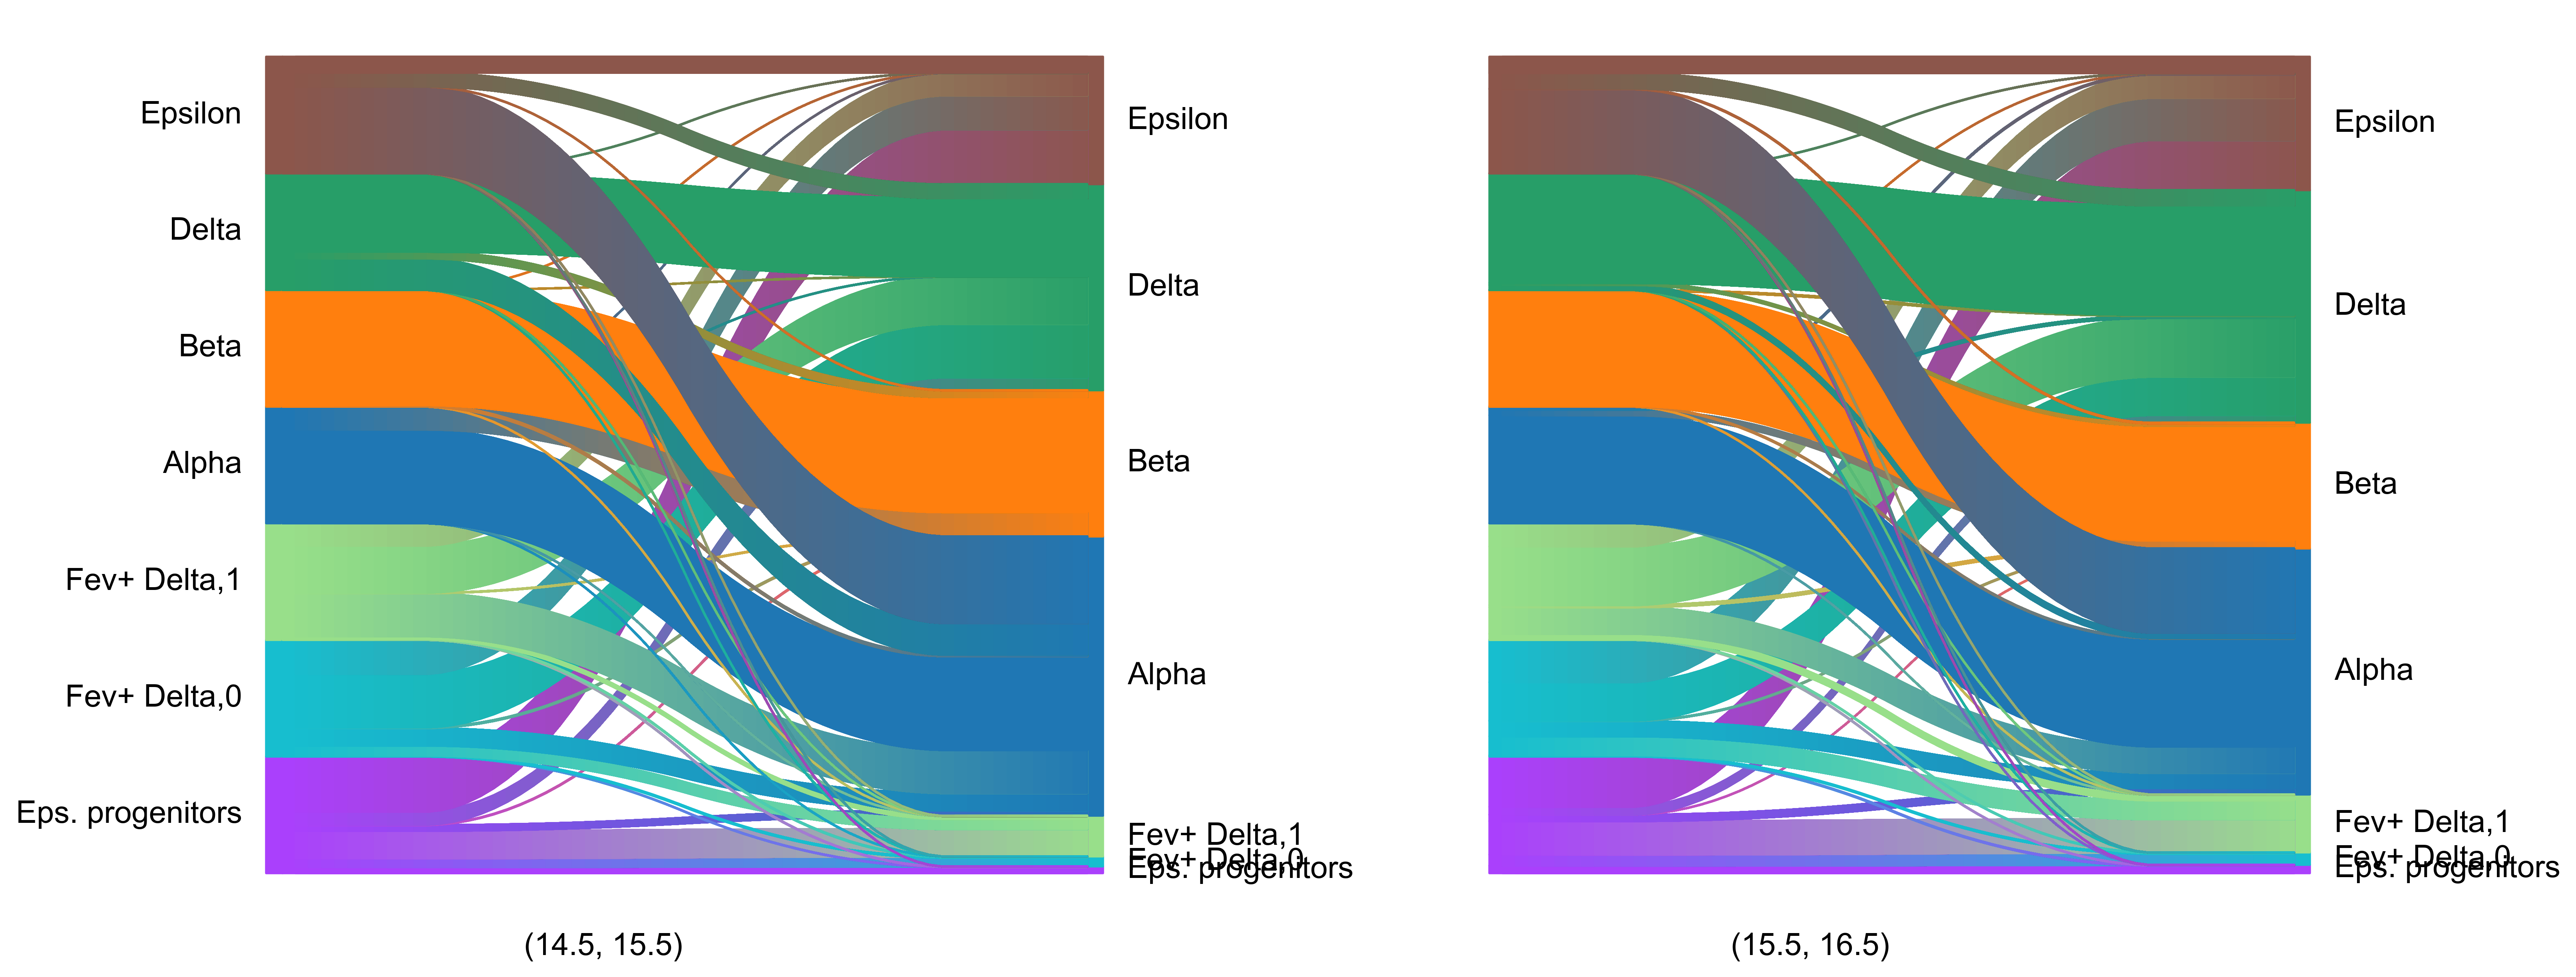

In [18]:
mpl.sankey(tp0, dpi=200, figsize=(16, 6), fontsize=14, interpolate_color=True)

This figure again illustrates some of the previous findings like mature endocrine cells mainly developing into themselves as well as epsilon cells 
primarily developing into alpha cells. Additionally we also see that the majority of epsilon progenitor cells develops into epsilon and Fev+ delta cells,
while there seem to be developmental differences between Fev+ delta 0 and 1 cells.